In [1]:
# Import necessary libraries. 
import matplotlib.pyplot as plt
import numpy as np
from cartopy import crs as ccrs
import pygeoinf as inf
from pygeoinf.homogeneous_space.sphere import Sobolev
from pyslfp import EarthModelParamters, FingerPrint

# Set up the FingerPrint instance
fingerprint = FingerPrint(
    lmax=128,
    earth_model_parameters=EarthModelParamters.from_standard_non_dimensionalisation(),
)
fingerprint.set_state_from_ice_ng()

# Function for generating random ocean locations.
def random_ocean_locations(n, lat1=-90, lat2=90):
    """
    Returns a set of n points within the oceans. An optional
    range of latitudes can be provided.
    """
    lats = []
    lons = []
    while len(lats) < n:
        lat = np.random.uniform(lat1, lat2)
        lon = np.random.uniform(-180, 180)
        sl = fingerprint.point_evaulation(fingerprint.sea_level, lat, lon)
        if sl > 0:
            lats.append(lat)
            lons.append(lon)
    return np.array(lats), np.array(lons)

In [2]:
# Set the model space for the ice thickness change. 
model_space = Sobolev(
    fingerprint.lmax, 2, 0.1, radius=fingerprint.mean_sea_floor_radius
)


# Set the ice projection operator.
ice_projection = inf.LinearOperator.formally_self_adjoint(
    model_space,
    lambda ice_thickness_change: fingerprint.ice_projection(0) * ice_thickness_change,
)

# Set the load projection.
load_projection = inf.LinearOperator.formally_self_adjoint(
    model_space, fingerprint.direct_load_from_ice_thickness_change
)


# Set a prior distribution.
model_prior_measure = model_space.sobolev_gaussian_measure(2, 0.05, 1)
model_prior_measure = model_prior_measure.affine_mapping(
    operator= ice_projection
)

# Set the sea level operator.
sea_level_operator = inf.LinearOperator.formally_self_adjoint(
    model_space,
    lambda direct_load: fingerprint(direct_load=direct_load, rtol=1e-9)[0],
)
sea_level_operator = sea_level_operator @ load_projection @ ice_projection

# Set the observation operator.
n = 20
lats, lons = random_ocean_locations(n, lat1=-60, lat2=60)
observation_operator = model_space.point_evaluation_operator(lats, lons)

# Set the forward problem.
forward_operator = observation_operator @ sea_level_operator
data_space = forward_operator.codomain
data_error_measure = inf.GaussianMeasure.from_standard_deviation(data_space, 0.01)
forward_problem = inf.LinearForwardProblem(forward_operator, data_error_measure)

global mean sea level change = 0.010757412799175164
estimated global mean sea level change = 0.006171827530875904


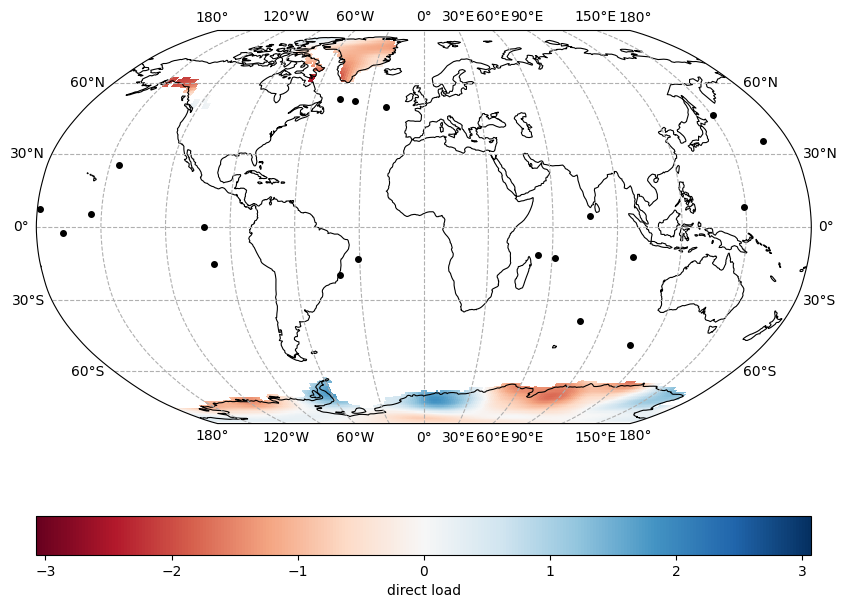

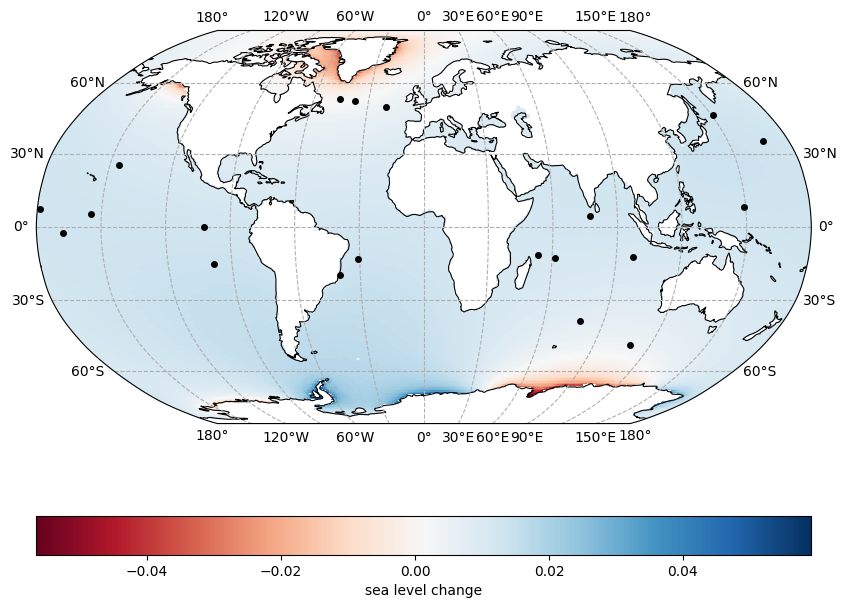

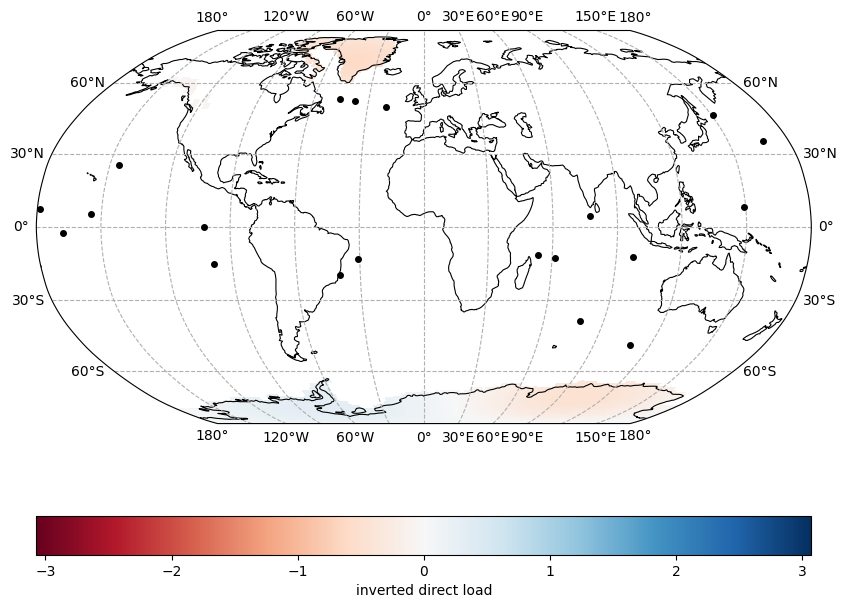

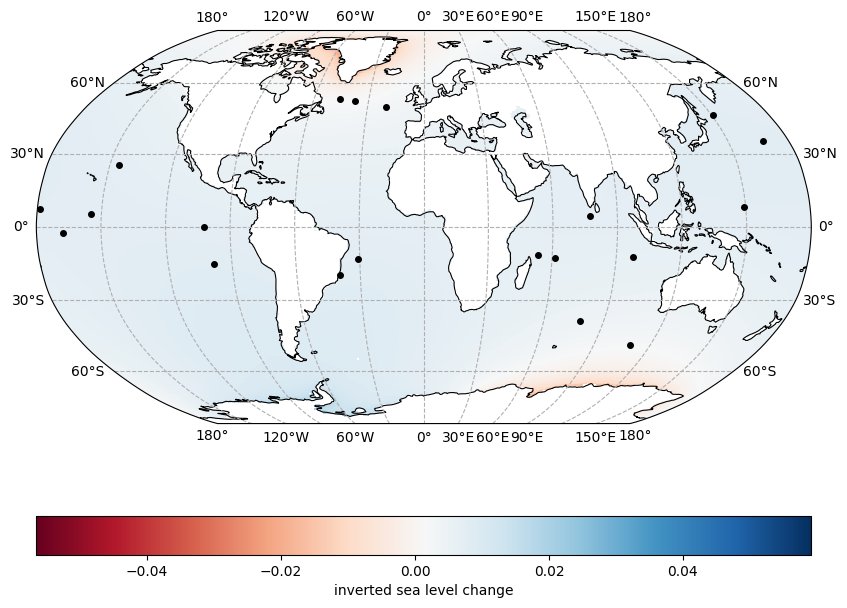

In [4]:

# Set up the inversion
inversion = inf.LinearBayesianInversion(forward_problem, model_prior_measure)

# Generate synthetic data.
model, data = forward_problem.synthetic_model_and_data(model_prior_measure)
sea_level_change = sea_level_operator(model)

# Plot the direct load input.
fig, ax, im = fingerprint.plot(model, ice_projection=True, symmetric=True)
model_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="direct load")
ax.plot(
    lons,
    lats,
    "o",
    color="k",
    markersize=4,
    transform=ccrs.PlateCarree(),
)

# Plot the resulting sea level
fig, ax, im = fingerprint.plot(sea_level_change, ocean_projection=True)
sea_clim = im.get_clim()
fig.colorbar(im, ax=ax, orientation="horizontal", label="sea level change")
ax.plot(
    lons,
    lats,
    "o",
    color="k",
    markersize=4,
    transform=ccrs.PlateCarree(),
)


# Invert the data.
pi = inversion.model_posterior_measure(data, inf.CGMatrixSolver())
inverted_model = pi.expectation
inverted_sea_level_change = sea_level_operator(inverted_model)


# Plot the inverted direct load input.
fig, ax, im = fingerprint.plot(inverted_model, ice_projection=True)
im.set_clim(model_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted direct load")
ax.plot(
    lons,
    lats,
    "o",
    color="k",
    markersize=4,
    transform=ccrs.PlateCarree(),
)

# Plot the resulting sea level
fig, ax, im = fingerprint.plot(inverted_sea_level_change, ocean_projection=True)
im.set_clim(sea_clim)
fig.colorbar(im, ax=ax, orientation="horizontal", label="inverted sea level change")
ax.plot(
    lons,
    lats,
    "o",
    color="k",
    markersize=4,
    transform=ccrs.PlateCarree(),
)

print(f"global mean sea level change = {fingerprint.ocean_average(sea_level_change)}")
print(
    f"estimated global mean sea level change = {fingerprint.ocean_average(inverted_sea_level_change)}"
)

plt.show()
